In [1]:
import sys
sys.path.append('../../')
from panav.env import NavigationEnv, Box2DRegion, PolygonRegion, box_2d_center, line_seg_to_obstacle
from panav.viz import draw_env

import shapely
import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

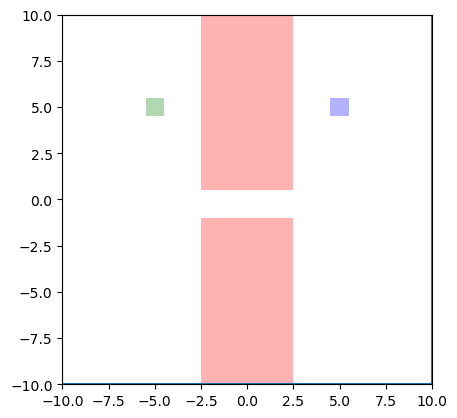

In [2]:

start_locs = np.array([[5,5]])
goal_locs = np.array([[-5,5]])


start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

starts = [box_2d_center(s,start_box_side) for s in start_locs]

goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

O1 = Box2DRegion((-2.5,2.5),(0.5,10))
O2 = Box2DRegion((-2.5,2.5),(-10,-1.0))

limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 

env = NavigationEnv(limits,[O1,O2],starts,goals)

draw_env(env)

# The RRT algorithm: LaValle 1998

**Important primitive functions for RRT**

In [3]:
import shapely
from numpy import linalg as la
def uniform_rand_loc(env):
    return np.random.uniform(low = [env.limits[0][0],env.limits[1][0]],
                    high = [env.limits[0][1],env.limits[1][1]])


def in_env_boundary(env,x,bloating_r):
    return env.limits[0][0]+bloating_r<=x[0]<=env.limits[0][1]-bloating_r\
          and env.limits[1][0]+bloating_r<=x[1]<=env.limits[1][1]-bloating_r
    
def has_point_collision(env,x,bloating_r):
    '''
        Output: whether putting an agent with bloating radius=bloating_r at location x in env induces collision.
    '''
    if in_env_boundary(env,x,bloating_r):
        for o in env.obstacles:           
            if shapely.Point(x).distance(o.vertices())<bloating_r:
                return True
        return False
    else:
        Warning("The test location x={} is not within the limits of the environment.".format(x))
        return True 

def has_line_collision(env,x1,x2,bloating_r):
    '''
        Output: whether the bloated line segment x1-x2 with bloating radius = bloating_r intersects with any of the obstacles in env.
    '''
    if in_env_boundary(env,x1,bloating_r) and in_env_boundary(env,x2,bloating_r):
        l = shapely.LineString([x1,x2]) 
        for o in env.obstacles:
            if l.distance(o.vertices())<bloating_r:
                return True
        return False
    else:
        Warning("The test locations may not be within the limits of the environment.")
        return True 

def binary_line_search(env,x_start,x_target,bloating_r,
                       eta = None,eps = 1e-5):
    '''
        A heuristic to decide a new 
        Output: min_x ||x-x_target|| such that 
               0) x lies on x_start-x_target
               1) has_line_collision(env,x_start,x,bloating_r) is False
               2) If eta is not None, then also ||x-x_start||<=eta. 
    '''
    
    
    if eta is not None:
        direction = x_target-x_start
        x_target = x_start + eta * direction/la.norm(direction)

    lo = 0
    hi = 1
    while hi-lo>eps:
        mid = (hi+lo)/2
        # print(hi,lo,mid)
        x_cur = x_start * (1-mid) + x_target * mid
        if has_line_collision(env,x_start,x_cur,bloating_r):
            # Shrink the line segment
            hi = mid
        else:
            # Expand the line segment
            lo = mid

    return x_cur

True


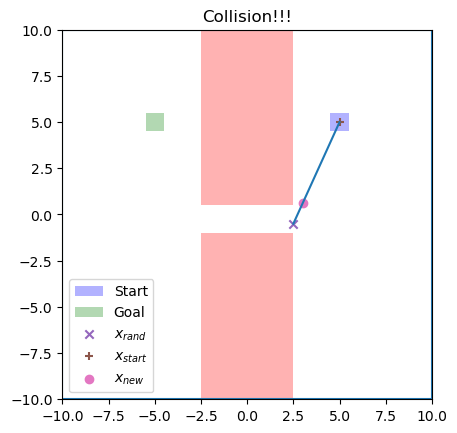

In [7]:
ax = plt.gca()
x_rand = uniform_rand_loc(env)
# x_rand = np.array([9.6,2.0])
# x_rand = np.array([2.5,-0.5])

x_new = binary_line_search(env,start_locs[0],x_rand,bloating_r)

# coll = has_collision(env,x_rand,bloating_r)
coll = has_line_collision(env,start_locs[0],x_rand,bloating_r)
draw_env(env,ax=ax)



ax.scatter(*x_rand,marker = 'x',label = r'$x_{rand}$')
ax.scatter(*start_locs[0],marker = "+",label = r'$x_{start}$')
ax.scatter(*x_new, marker = "o",label = r'$x_{new}$')
ax.plot([x_rand[0],start_locs[0][0]],[x_rand[1],start_locs[0][1]])


ax.set_title("Collision!!!" if coll else "No collision")
print(coll)
ax.legend()
plt.show()


In [42]:
# Test faiss
import faiss
import numpy as np
d = 2                           # dimension
nb = 10                      # database size
np.random.seed(1234)             # make reproducible
xb = np.random.random((nb, d)).astype('float32')
xq = np.array([0.9,0.6]).reshape(1,d)

###################################
index = faiss.IndexFlatL2(d)
index.add(xb) # Highlight
nn_dist, nn_i = index.search(xq,1) # Highlight

nn = xb[nn_i].flatten()
###################################


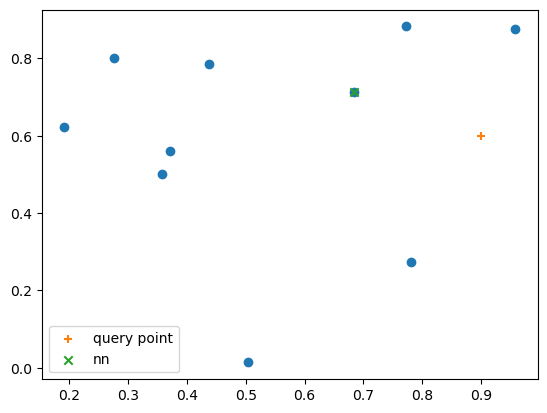

In [44]:
plt.scatter(xb[:,0],xb[:,1])
plt.scatter(*(xq.flatten()),marker = '+',label = 'query point')
plt.scatter(*(nn.flatten()),marker = 'x',label = 'nn')
plt.legend()
plt.show()

In [182]:
from networkx import DiGraph
class RRT(DiGraph):
    def __init__(self,x_init):
        super().__init__()
        self.add_node(0,loc = x_init,tol_cost = 0)
        self.d = len(x_init)
        self.nn_index = faiss.IndexFlatL2(self.d) # The data structure for efficient nearest neighbor computation.
        self.nn_index.add(x_init.reshape(-1,self.d))
    def nearest(self,xq):
        xq = np.array(xq).reshape(1,self.d)
        _, nn_i = self.nn_index.search(xq,1) 

        nn_i = nn_i.item() # Get the scalar in the singleton array
        return nn_i,self.nodes[nn_i]['loc']
    
    def add_loc(self,parent,x_new):
        x_parent = self.nodes[parent]['loc']

        self.add_node(self.number_of_nodes(),loc = x_new,
                      tol_cost = self.nodes[parent]['tol_cost']+la.norm(x_parent-x_new))

        self.add_edge(parent,self.number_of_nodes()-1)
        
        self.nn_index.add(x_new.reshape(-1,self.d))


In [268]:


def RRT_plan(env,x_start,bloating_r,max_iter = 100000,eta = 0.1):
    def backtrack(i,T):
        plan = []
        pred = list(T.predecessors(i))
        while i is not None:
            plan.append(T.nodes[i]['loc'])
            if len(pred)>0:
                i = pred[0]
                pred = list(T.predecessors(i))
            else:
                i = None

        return plan[::-1]
    # Simulate the RRT loop
    T = RRT(x_start)
    for _ in range(max_iter):
        x_rand = uniform_rand_loc(env)
        i_nearest,x_nearest = T.nearest(x_rand)
        x_new = binary_line_search(env,x_nearest,x_rand,bloating_r,
                                eta = 0.1)
        # Setting eta = None seems to result in th fast marching tree
        T.add_loc(i_nearest,x_new)
        
        # Stop when one feasible solution is found
        if env.goals[0].vertices().contains(shapely.Point(x_new)):
            return backtrack(T.number_of_nodes()-1,T),T 
    else:
        return [], T

def draw_rrt(ax,T):
    for e in T.edges():
        u,v = e
        seg = np.vstack([T.nodes[u]['loc'],T.nodes[v]['loc']])
        ax.plot(seg[:,0],seg[:,1],color="g")

In [279]:
plan,T = RRT_plan(env,start_locs[0],bloating_r,eta = 0.1)


In [280]:
plan = np.array(plan)

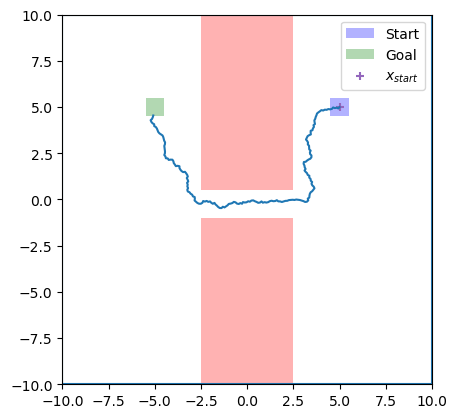

In [281]:


ax = plt.gca()

x_new = binary_line_search(env,start_locs[0],x_rand,bloating_r)

draw_env(env,ax=ax)

ax.scatter(*start_locs[0],marker = "+",label = r'$x_{start}$')

ax.plot(plan[:,0],plan[:,1])
# draw_rrt(ax,T)
ax.legend()
plt.show()
